# Finetuning FastPitch for a new speaker

In this tutorial, we will finetune a single speaker FastPitch (with alignment) model on 5 mins of a new speaker's data. We will finetune the model parameters only on the new speaker's text and speech pairs (though see the section at the end to learn more about mixing speaker data).

We will download the training data, then generate and run a training command to finetune Fastpitch on 5 mins of data, and synthesize the audio from the trained checkpoint.

A final section will describe approaches to improve audio quality past this notebook.

## License

> Copyright (c) 2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

With the English Normalizer and the EnglishPhonemeTokenizer it works.

The Spanish Normalizer works well, but the error occurs when I change the Tokenizer -> With the SpanishCharTokenizer it doesn't work.

Error: RuntimeError: Error(s) in loading state_dict for FastPitchModel:
size mismatch for fastpitch.encoder.word_emb.weight: copying a param with shape torch.Size([115, 384]) from checkpoint, the shape in # current model is torch.Size([59, 384]).

Maybe it has to do with the variables VOWELS, CONSONANTS and PUNCT_LIST? GitHub NeMo tts_tokenizers.py: https://github.com/NVIDIA/NeMo/blob/stable/nemo/collections/common/tokenizers/text_to_speech/tts_tokenizers.py


We run the following cells to download all the dependecies that we need, as well as the english model. They download some files. I have sent you all the necessary files:
- heteronyms-052722: English heteronyms
- cmudict-0.7b_nv22.10: English dictionary
- fastpitch_finetune.py: python script 
- Fastpitch_align_v2.05.yaml: configuration file
- es_ES_nv230301.dict: Spanish dictionary
- ./fastpitch_sup_datav2 \ -> this folder can be done with the script FastPitch_SpanishTTS_Training.ipynb
- val_manifest_text_normed.json -> can be created with FP_ES_TTS_ExtraccionTransformacionLimpiezaDataset.ipynb
- train_manifest_text_normed.json -> can be created with FP_ES_TTS_ExtraccionTransformacionLimpiezaDataset.ipynb

In [1]:
"""
You can either run this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.
Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
BRANCH = 'r1.19.0'
# If you're using Google Colab and not running locally, uncomment and run this cell.
# !apt-get install sox libsndfile1 ffmpeg
# !pip install wget text-unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/NVIDIA/NeMo.git (to revision r1.19.0) to /tmp/pip-install-634mj17_/nemo-toolkit_8d8eb9e7e54642ba94b515620fd2e8be
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-634mj17_/nemo-toolkit_8d8eb9e7e54642ba94b515620fd2e8be
  Running command git checkout -b r1.19.0 --track origin/r1.19.0
  Switched to a new branch 'r1.19.0'
  Branch 'r1.19.0' set up to track remote branch 'r1.19.0' from 'origin'.
  Resolved https://github.com/NVIDIA/NeMo.git to commit 2331b063d6f0282fa79c32e4e780db6cc7ef19f2
  distutils: /tmp/pip-build-env-ph1o03ir/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-ph1o03ir/normal/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-ph1o03ir/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-ph1o03ir/normal/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = 

## Downloading data

For our tutorial, we will use a small part of the Hi-Fi Multi-Speaker English TTS (Hi-Fi TTS) dataset. You can read more about dataset [here](https://arxiv.org/abs/2104.01497). We will use speaker 9017 as the target speaker, and only a 5-minute subset of audio will be used for this fine-tuning example. We additionally resample audio to 22050 kHz.

In [71]:
# !wget https://multilangaudiosamples.s3.us-east-2.amazonaws.com/9017_5_mins.tar.gz
# !tar -xzf 9017_5_mins.tar.gz

In [72]:
# !head -n 1 ./9017_5_mins/manifest.json

Let's take 2 samples from the dataset and split it off into a validation set. Then, split all other samples into the training set.

As mentioned, since the paths in the manifest are relative, we also create a symbolic link to the audio folder such that `audio/` goes to the correct directory.

In [73]:
# !cat ./9017_5_mins/manifest.json | tail -n 2 > ./9017_manifest_dev_ns_all_local.json
# !cat ./9017_5_mins/manifest.json | head -n -2 > ./9017_manifest_train_dur_5_mins_local.json
# !ln -s ./9017_5_mins/audio audio

Let's also download the pretrained checkpoint that we want to finetune from. NeMo will save checkpoints to `~/.cache`, so let's move that to our current directory.

*Note: please, check that `home_path` refers to your home folder. Otherwise, change it manually.*

In [2]:
home_path = !(echo $HOME)
home_path = home_path[0]
print(home_path)

/root


In [3]:
import os
import json

import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

from nemo.collections.tts.models import FastPitchModel
FastPitchModel.from_pretrained("tts_en_fastpitch")

from pathlib import Path
nemo_files = [p for p in Path(f"{home_path}/.cache/torch/NeMo/").glob("**/tts_en_fastpitch_align.nemo")]
print(f"Copying {nemo_files[0]} to ./")
Path("./tts_en_fastpitch_align.nemo").write_bytes(nemo_files[0].read_bytes())

[NeMo W 2023-07-10 14:45:04 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-10 14:45:04 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-10 14:45:04 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-10 14:45:04 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-10 14:45:05 experimental:27] Module <class 'nemo.collections.tts.models.ssl_tts.SSLDisentangler'> is expe

[NeMo I 2023-07-10 14:45:05 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
[NeMo I 2023-07-10 14:45:05 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo
[NeMo I 2023-07-10 14:45:05 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-10 14:45:31 fastpitch:232] This checkpoint support will be dropped after NeMo 1.18.0.
[NeMo W 2023-07-10 14:45:32 experimental:27] Module <class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-10 14:45:32 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-10 14:45:32 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
  

[NeMo I 2023-07-10 14:45:32 features:291] PADDING: 1
[NeMo I 2023-07-10 14:45:33 save_restore_connector:249] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
Copying /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo to ./


187023360

To finetune the FastPitch model on the above created filelists, we use the `examples/tts/fastpitch_finetune.py` script to train the models with the `fastpitch_align_v1.05.yaml` configuration.

Let's grab those files.

In [5]:
# !cd NemoSpanishTTS \
# && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/conf/fastpitch_align_v1.05.yaml \
# && wget https://raw.githubusercontent.com/nvidia/NeMo/$BRANCH/examples/tts/fastpitch_finetune.py \
# && cd ..

We also need some additional files (see `FastPitch_MixerTTS_Training.ipynb` tutorial for more details) for training. Let's download these, too.

In [6]:
# # additional files
# #Se crea dentro de NemoSpanishTTS
# !mkdir -p tts_dataset_files && cd tts_dataset_files \
# && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.10 \
# && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
# && cd ..

## Finetuning FastPitch

We can now train our model with the following command:

**NOTE: This will take about 50 minutes on colab's K80 GPUs.**

The train command is in the fptts-train.sh

In [1]:
# os.chdir("/home/irene/datasets")

# # TODO(oktai15): remove +model.text_tokenizer.add_blank_at=true when we update FastPitch checkpoint
# !(cd ./NemoSpanishTTS && python fastpitch_finetune.py --config-name=fastpitch_align_v2.05.yaml \
#   train_dataset=train_manifest_text_normed.json \
#   validation_datasets=val_manifest_text_normed.json \
#   sup_data_path=./fastpitch_sup_datav2 \
#   phoneme_dict_path=es_ES_nv230301.dict \
#   exp_manager.exp_dir=./ljspeech_to_9017_no_mixing_5_minsv2 \
#   +init_from_nemo_model=./tts_en_fastpitch_align.nemo \
#   +trainer.max_steps=1000 ~trainer.max_epochs \
#   trainer.check_val_every_n_epoch=25 \
#   model.train_ds.dataloader_params.batch_size=4 model.validation_ds.dataloader_params.batch_size=4 \
#   model.n_speakers=1 model.pitch_mean=126.73465728759766 model.pitch_std=38.099849700927734 \
#   model.pitch_fmin=30 model.pitch_fmax=512 model.optim.lr=2e-4 \
#   ~model.optim.sched model.optim.name=adam trainer.devices=1 trainer.strategy=null \
#   +model.text_tokenizer.add_blank_at=true \
# )
#   # heteronyms_path=tts_dataset_files/heteronyms-052722 \

Let's take a closer look at the training command:

* `--config-name=fastpitch_align_v1.05.yaml`
  * We first tell the script what config file to use.

* `train_dataset=./9017_manifest_train_dur_5_mins_local.json
  validation_datasets=./9017_manifest_dev_ns_all_local.json
  sup_data_path=./fastpitch_sup_data`
  * We tell the script what manifest files to train and eval on, as well as where supplementary data is located (or will be calculated and saved during training if not provided).
  
* `phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.10
heteronyms_path=tts_dataset_files/heteronyms-052722
`
  * We tell the script where `phoneme_dict_path` and `heteronyms-052722` are located. These are the additional files we downloaded earlier, and are used in preprocessing the data.
  
* `exp_manager.exp_dir=./ljspeech_to_9017_no_mixing_5_mins`
  * Where we want to save our log files, tensorboard file, checkpoints, and more.

* `+init_from_nemo_model=./tts_en_fastpitch_align.nemo`
  * We tell the script what checkpoint to finetune from.

* `+trainer.max_steps=1000 ~trainer.max_epochs trainer.check_val_every_n_epoch=25`
  * For this experiment, we tell the script to train for 1000 training steps/iterations rather than specifying a number of epochs to run. Since the config file specifies `max_epochs` instead, we need to remove that using `~trainer.max_epochs`.

* `model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24`
  * Set batch sizes for the training and validation data loaders.

* `model.n_speakers=1`
  * The number of speakers in the data. There is only 1 for now, but we will revisit this parameter later in the notebook.

* `model.pitch_mean=152.3 model.pitch_std=64.0 model.pitch_fmin=30 model.pitch_fmax=512`
  * For the new speaker, we need to define new pitch hyperparameters for better audio quality.
  * These parameters work for speaker 9017 from the Hi-Fi TTS dataset.
  * If you are using a custom dataset, running the script `python <NeMo_base>/scripts/dataset_processing/tts/extract_sup_data.py manifest_filepath=<your_manifest_path>` will precalculate supplementary data and print these pitch stats.
  * fmin and fmax are hyperparameters to librosa's pyin function. We recommend tweaking these only if the speaker is in a noisy environment, such that background noise isn't predicted to be speech.

* `model.optim.lr=2e-4 ~model.optim.sched model.optim.name=adam`
  * For fine-tuning, we lower the learning rate.
  * We use a fixed learning rate of 2e-4.
  * We switch from the lamb optimizer to the adam optimizer.

* `trainer.devices=1 trainer.strategy=null`
  * For this notebook, we default to 1 gpu which means that we do not need ddp.
  * If you have the compute resources, feel free to scale this up to the number of free gpus you have available.
  * Please remove the `trainer.strategy=null` section if you intend on multi-gpu training.

## Synthesize Samples from Finetuned Checkpoints

Once we have finetuned our FastPitch model, we can synthesize the audio samples for given text using the following inference steps. We use a HiFi-GAN vocoder trained on LJSpeech.

We define some helper functions as well.

In [2]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

vocoder = HifiGanModel.from_pretrained("tts_en_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo W 2023-07-04 12:40:40 experimental:27] Module <class 'nemo.collections.asr.modules.audio_modules.SpectrogramToMultichannelFeatures'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-04 12:40:40 experimental:27] Module <class 'nemo.collections.tts.models.fastpitch_ssl.FastPitchModel_SSL'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-04 12:40:40 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-04 12:40:40 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2023-07-04 12:40:40 experimental:27] Module <class 'nemo.collections.tts.models.ssl_tts.SSLDisentangler'> is expe

[NeMo I 2023-07-04 12:40:40 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.19.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2023-07-04 12:40:40 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.19.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2023-07-04 12:40:40 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-04 12:40:42 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2023-07-04 12:40:42 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2023-07-04 12:40:42 features:291] PADDING: 0


[NeMo W 2023-07-04 12:40:42 features:268] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2023-07-04 12:40:42 features:291] PADDING: 0
[NeMo I 2023-07-04 12:40:43 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.19.0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


In [3]:
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.

    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID

    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)

    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt_from_last_run(
        base_dir,
        new_speaker_id,
        duration_mins,
        mixing_enabled,
        original_speaker_id,
        model_name="FastPitch"
    ):
    mixing = "no_mixing" if not mixing_enabled else "mixing"

    d = f"{original_speaker_id}_to_{new_speaker_id}_{mixing}_{duration_mins}_mins"

    exp_dirs = list([i for i in (Path(base_dir) / d / model_name).iterdir() if i.is_dir()])
    last_exp_dir = sorted(exp_dirs)[-1]

    last_checkpoint_dir = last_exp_dir / "checkpoints"

    last_ckpt = list(last_checkpoint_dir.glob('*-last.ckpt'))

    if len(last_ckpt) == 0:
        raise ValueError(f"There is no last checkpoint in {last_checkpoint_dir}.")

    return str(last_ckpt[0])

Specify the speaker ID, duration of the dataset in minutes, and speaker mixing variables to find the relevant checkpoint (for example, we've saved our model in `ljspeech_to_9017_no_mixing_5_mins/`) and compare the synthesized audio with validation samples of the new speaker.

The mixing variable is False for now, but we include some code to handle multiple speakers for reference.

In [19]:
# load fastpitch and hifigan models
import glob, os
os.chdir("/home/irene/datasets/NemoSpanishTTS/ljspeech_to_9017_no_mixing_5_mins/")

file_list = glob.glob("/home/irene/datasets/NemoSpanishTTS/ljspeech_to_9017_no_mixing_5_minsv2/FastPitch/2023-07-04_12-30-53/checkpoints/*")
fastpitch_model_path = sorted(file_list, key=os.path.basename)[1] # path_to_fastpitch_nemo_or_ckpt
print("# CARGAREMOS EL MODELO ....... : ", os.path.basename(fastpitch_model_path))
print("# DE LA CARPETA .............. : ", os.path.dirname(fastpitch_model_path))

if ".nemo" in fastpitch_model_path:
    spec_gen_model_finetuned = FastPitchModel.restore_from(fastpitch_model_path).eval().cuda()
else:
    spec_gen_model_finetuned = FastPitchModel.load_from_checkpoint(checkpoint_path=fastpitch_model_path).eval().cuda()

# CARGAREMOS EL MODELO ....... :  FastPitch.nemo
# DE LA CARPETA .............. :  /home/irene/datasets/NemoSpanishTTS/ljspeech_to_9017_no_mixing_5_minsv2/FastPitch/2023-07-04_12-30-53/checkpoints


[NeMo W 2023-07-04 12:44:23 fastpitch:232] This checkpoint support will be dropped after NeMo 1.18.0.
[NeMo W 2023-07-04 12:44:24 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-04 12:44:24 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.dataset.TTSDataset
      manifest_filepath: train_manifest_text_normed.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_datav2
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      

[NeMo I 2023-07-04 12:44:24 features:291] PADDING: 1
[NeMo I 2023-07-04 12:44:24 save_restore_connector:249] Model FastPitchModel was successfully restored from /home/irene/datasets/NemoSpanishTTS/ljspeech_to_9017_no_mixing_5_minsv2/FastPitch/2023-07-04_12-30-53/checkpoints/FastPitch.nemo.


In [20]:
def evaluate_spec_fastpitch_ckpt(spec_gen_model, v_model, test, speaker=None):
    seed = random.randint(100000, 999999)
#   print(seed)
    with torch.no_grad():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False
        parsed = spec_gen_model.parse(str_input=test, normalize=True)
        if speaker == None:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        else:
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        print(spectrogram.size())
        audio = v_model.convert_spectrogram_to_audio(spec=spectrogram)

    spectrogram = spectrogram.to('cpu').numpy()[0]
    audio = audio.to('cpu').numpy()[0]
    audio = audio / np.abs(audio).max()
    return audio, spectrogram

original audio


[NeMo W 2023-07-04 12:47:50 tts_tokenizers:477] Text: [estËoÉª aÎ²lËando Ëen espanol aËoÉ¾a mËismo, pËeÉ¾o todavia no muy bjËen] contains unknown char/phoneme: [estËoÉª].Original text: [Estoy hablando en espanol ahora mismo, pero todavia no muy bien]. Symbol will be skipped.
[NeMo W 2023-07-04 12:47:50 tts_tokenizers:477] Text: [estËoÉª aÎ²lËando Ëen espanol aËoÉ¾a mËismo, pËeÉ¾o todavia no muy bjËen] contains unknown char/phoneme: [aÎ²lËando].Original text: [Estoy hablando en espanol ahora mismo, pero todavia no muy bien]. Symbol will be skipped.
[NeMo W 2023-07-04 12:47:50 tts_tokenizers:477] Text: [estËoÉª aÎ²lËando Ëen espanol aËoÉ¾a mËismo, pËeÉ¾o todavia no muy bjËen] contains unknown char/phoneme: [Ëen].Original text: [Estoy hablando en espanol ahora mismo, pero todavia no muy bien]. Symbol will be skipped.
[NeMo W 2023-07-04 12:47:50 tts_tokenizers:477] Text: [estËoÉª aÎ²lËando Ëen espanol aËoÉ¾a mËismo, pËeÉ¾o todavia no muy bjËen] contains unkno

torch.Size([1, 80, 166])


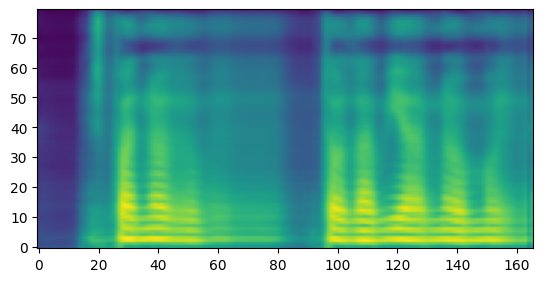

Finetuned EN model [tts_en_fastpitch]:


In [33]:
import numpy as np
import random

test = "Estoy hablando en español ahora mismo, pero todavía no muy bien"
test_id = "19demarzo_3262" # identifier for the audio corresponding to the test text
data_path = "/home/irene/datasets/datasetCastellanoReducido/19demarzo/" # path to dataset folder with wav files from original dataset
# audio
print("original audio")
ipd.display(ipd.Audio(data_path+test_id+'.wav', rate=22050))

audio_finetuned, spectrogram_finetuned = evaluate_spec_fastpitch_ckpt(spec_gen_model_finetuned, vocoder, test)

# visualize the spectrogram
if spectrogram_finetuned is not None:
    imshow(spectrogram_finetuned, origin="lower")
    plt.show()
print("Finetuned EN model [tts_en_fastpitch]:")
ipd.display(ipd.Audio(audio_finetuned, rate=22050))

In [1]:

# import os
# from pathlib import Path
# new_speaker_id = 9017
# duration_mins = 5
# mixing = False
# original_speaker_id = "ljspeech"

# print("Recupero fichero de la carpeta")
# last_ckpt = get_best_ckpt_from_last_run("./", new_speaker_id, duration_mins, mixing, original_speaker_id)
# print(last_ckpt)

# spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
# spec_model.eval().cuda()

# # Only need to set speaker_id if there is more than one speaker
# speaker_id = None
# if mixing:
#     speaker_id = 1

# num_val = 2  # Number of validation samples
# val_records = []
# with open(f"{new_speaker_id}_manifest_dev_ns_all_local.json", "r") as f:
#     for i, line in enumerate(f):
#         val_records.append(json.loads(line))
#         if len(val_records) >= num_val:
#             break

# for val_record in val_records:
#     print("Real validation audio")
#     ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
#     print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
#     spec, audio = infer(spec_model, vocoder, val_record['text'], speaker=speaker_id)
#     ipd.display(ipd.Audio(audio, rate=22050))
#     %matplotlib inline
#     imshow(spec, origin="lower", aspect="auto")
#     plt.show()

## Improving Speech Quality

We see that from fine-tuning FastPitch, we were able to generate audio in a male voice but the audio quality is not as good as we expect. We recommend two steps to improve audio quality:

* Finetuning HiFi-GAN
* Adding more data

**Note that both of these steps are outside the scope of the notebook due to the limited compute available on Colab, but the code is included below for you to use outside of this notebook.**

### Finetuning HiFi-GAN
From the synthesized samples, there might be audible audio crackling. To fix this, we need to finetune HiFi-GAN on the new speaker's data. HiFi-GAN shows improvement using **synthesized mel spectrograms**, so the first step is to generate mel spectrograms with our finetuned FastPitch model to use as input.

The code below uses our finetuned model to generate synthesized mels for the training set we have been using. You will also need to do the same for the validation set (code should be very similar, just with paths changed).

In [4]:
# import json
# import numpy as np
# import torch
# import soundfile as sf

# from pathlib import Path

# from nemo.collections.tts.parts.utils.tts_dataset_utils import BetaBinomialInterpolator


# def load_wav(audio_file, target_sr=None):
#     with sf.SoundFile(audio_file, 'r') as f:
#         samples = f.read(dtype='float32')
#         sample_rate = f.samplerate
#         if target_sr is not None and target_sr != sample_rate:
#             samples = librosa.core.resample(samples, orig_sr=sample_rate, target_sr=target_sr)
#     return samples.transpose()

# # Get records from the training manifest
# manifest_path = "./9017_manifest_train_dur_5_mins_local.json"
# records = []
# with open(manifest_path, "r") as f:
#     for i, line in enumerate(f):
#         records.append(json.loads(line))

# beta_binomial_interpolator = BetaBinomialInterpolator()
# spec_model.eval()

# device = spec_model.device

# save_dir = Path("./9017_manifest_train_dur_5_mins_local_mels")
# save_dir.mkdir(exist_ok=True, parents=True)

# # Generate a spectrograms (we need to use ground truth alignment for correct matching between audio and mels)
# for i, r in enumerate(records):
#     audio = load_wav(r["audio_filepath"])
#     audio = torch.from_numpy(audio).unsqueeze(0).to(device)
#     audio_len = torch.tensor(audio.shape[1], dtype=torch.long, device=device).unsqueeze(0)

#     # Again, our finetuned FastPitch model doesn't use multiple speakers,
#     # but we keep the code to support it here for reference
#     if spec_model.fastpitch.speaker_emb is not None and "speaker" in r:
#         speaker = torch.tensor([r['speaker']]).to(device)
#     else:
#         speaker = None

#     with torch.no_grad():
#         if "normalized_text" in r:
#             text = spec_model.parse(r["normalized_text"], normalize=False)
#         else:
#             text = spec_model.parse(r['text'])

#         text_len = torch.tensor(text.shape[-1], dtype=torch.long, device=device).unsqueeze(0)

#         spect, spect_len = spec_model.preprocessor(input_signal=audio, length=audio_len)

#         # Generate attention prior and spectrogram inputs for HiFi-GAN
#         attn_prior = torch.from_numpy(
#           beta_binomial_interpolator(spect_len.item(), text_len.item())
#         ).unsqueeze(0).to(text.device)

#         spectrogram = spec_model.forward(
#           text=text,
#           input_lens=text_len,
#           spec=spect,
#           mel_lens=spect_len,
#           attn_prior=attn_prior,
#           speaker=speaker,
#         )[0]

#         save_path = save_dir / f"mel_{i}.npy"
#         np.save(save_path, spectrogram[0].to('cpu').numpy())
#         r["mel_filepath"] = str(save_path)

# hifigan_manifest_path = "hifigan_train_ft.json"
# with open(hifigan_manifest_path, "w") as f:
#     for r in records:
#         f.write(json.dumps(r) + '\n')
# # Please do the same for the validation json. Code is omitted.

We can then finetune hifigan similarly to fastpitch using NeMo's [hifigan_finetune.py](https://github.com/NVIDIA/NeMo/blob/r1.19.0/examples/tts/hifigan_finetune.py) and [hifigan.yaml](https://github.com/NVIDIA/NeMo/blob/r1.19.0/examples/tts/conf/hifigan/hifigan.yaml):

```bash
python examples/tts/hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=32 \
model.max_steps=1000 \
model.optim.lr=0.00001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_val_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_pretrained_model=tts_en_hifigan \
trainer.check_val_every_n_epoch=10 \
model/train_ds=train_ds_finetune \
model/validation_ds=val_ds_finetune
```

Like when finetuning FastPitch, we lower the learning rate and get rid of the optimizer schedule for finetuning. You will need to create `<your_hifigan_val_manifest>` and the synthesized mels corresponding to it.

As mentioned, the above command is not runnable in Colab due to limited compute resources, but you are free to finetune HiFi-GAN on your own machines.

### Adding more data
We can add more data in two ways. They can be combined for the best effect:

* **Add more training data from the new speaker**

The entire notebook can be repeated from the top after a new JSON manifest is defined that includes the additional data. Modify your finetuning commands to point to the new manifest. Be sure to increase the number of steps as more data is added to both the FastPitch and HiFi-GAN finetuning.

We recommend **1000 steps per minute of audio for fastpitch and 500 steps per minute of audio for HiFi-GAN**.

* **Mix new speaker data with old speaker data**

We recommend finetuning FastPitch (but not HiFi-GAN) using both old speaker data (LJSpeech in this notebook) and the new speaker data. In this case, please modify the JSON manifests when finetuning FastPitch to include speaker information by adding a `speaker` field to each entry:

```
{"audio_filepath": "new_speaker.wav", "text": "sample", "duration": 2.6, "speaker": 1}
{"audio_filepath": "old_speaker.wav", "text": "LJSpeech sample", "duration": 2.6, "speaker": 0}
```

5 hours of data from the old speaker should be sufficient for training; it's up to you how much data from the old speaker to use in validation.

For the training manifest, since we likely have less data from the new speaker, we need to ensure that the model sees a similar amount of new data and old data. We can do this by repeating samples from the new speaker until we have an equivalent number of samples from the old and new speaker. For each sample from the old speaker, please add a sample from the new speaker in the .json.

As a toy example, if we use 4 samples of the old speaker and only 2 samples of the new speaker, we would want the order of samples in our manifest to look something like this:

```
old_speaker_sample_0
new_speaker_sample_0
old_speaker_sample_1
new_speaker_sample_1
old_speaker_sample_2
new_speaker_sample_0  # Start repeat of new speaker samples
old_speaker_sample_3
new_speaker_sample_1
```

Once the manifests are created, we can modify the FastPitch training command to point to the new training and validation JSON files.

We also need to update `model.n_speakers=1` to `model.n_speakers=2`, as well as update the `sup_data_types` specified in the config file to include `speaker_id` (`sup_data_types=[align_prior_matrix,pitch,speaker_id]`). Updating these two fields is very important--otherwise the model will not recognize that there is more than one speaker!

Ensure the pitch statistics correspond to the new speaker rather than the old speaker for best results.

**For HiFiGAN finetuning, the training should be done on the new speaker data.**